## PyTorch Workflow

Let's explore a an example PyTorch end-to-end workflow.

In [1]:
what_were_building = {1: 'data (prepare and load)',
                      2: 'build model',
                      3: 'fitting the model to data (training)',
                      4: 'making preditctions and evaluating a model (inference)',
                      5: 'saving and loading a model',
                      6: 'putting it all together'}
what_were_building

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making preditctions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# check PyTorch version
torch.__version__

'2.2.1+cu121'

## 1. Data (Preparing and loading)

Data can be almost anything... in machine learning.

* Excel speadsheet
* Images of any kind
* Videos (Youtube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representations.
2. Build a model to learn patterns in the numerical representation.

To showcase this, let's create some *known* data using the linear regression formula.

we'll use a linear regression formula to make a straight line with *known* **parameters**.

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

print(X.shape)

X[:10], y[:10]

torch.Size([50, 1])


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create s training and test set with our data.

In [5]:
# create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize, visualize, visualize!"

In [6]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize = (10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s = 4, label = "Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s = 4, label = "Testing data")

  # Are there predictions?
  if predictions is not None:
    # plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=  4, label = "Predictions")

  # show the legend
  plt.legend(prop={"size" : 14});

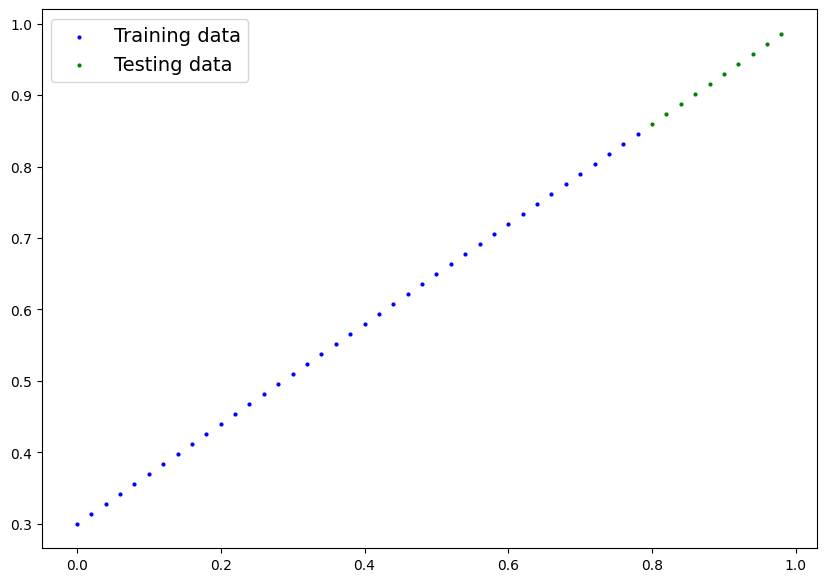

In [7]:
plot_predictions()

## 2. Building model

Our first PyTorch model!

This is very exciting...let's do it!

What our model does:
* Start with random values (weight and bias)
* Look at raining data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [8]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()

    # initialize model parameters
    # these could be:
    # 1. different layers from torch.nn
    # 2. single parameters
    # 3. hard-codded values
    # 4. functions
    self.weight = nn.Parameter(torch.randn(1, # <- start with random weight and try to adjust it to the ideal weight
                                           requires_grad=True,  #  <- can this parameter be updated via gradient descent?
                                           dtype = torch.float))  # <- PyTorch loves the datatype torch.float32
    self.bias = nn.Parameter(torch.randn(1,  # <- start with random weight and try to adjust it to the ideal weight
                                          requires_grad = True, #  <- can this parameter be updated via gradient descent?
                                          dtype = torch.float)) # <- PyTorch loves the datatype torch.float32
  # Forward method to define the computation in the model
  # Any subclass of nn.Module needs to override "forward()"
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weight * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

* torch.nn - contrains all of ther buildings for computational graphs (a neural network can be considered a computational graph).
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us.
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward().
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent.
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation.
* torch.utils.data.Dataset - represents a map between key (label) and sample (features) pairs of your data. such as images and their associated labels.
* torch.utils.data.DataLoader - creates a Python iterable over a torch Dataset (allows you to iterate over your data).

### Checking the content of our PyTorch model

Now we've created a model, let's see what's inside...
So we can check our model parameters or what's inside our model using `.parameters()`.

In [9]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named paramaters
# check out our model's parameters (a parameter is a value that the model sets itsaelf)
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how it will predict `y_test` based on `X_test`.
When we pass data through our model, it's going to run it through the `forward()` method.

In [11]:
y_pred = model_0(X_test)
y_pred

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [12]:
# Make predictions with model
with torch.inference_mode():
  y_pred = model_0(X_test)

# you can do something similar with torch.no_grad(), however, torch.inference_mode() is preffered

# with torch.no_grad():
#   y_pred = model_0(X_test)

y_pred

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

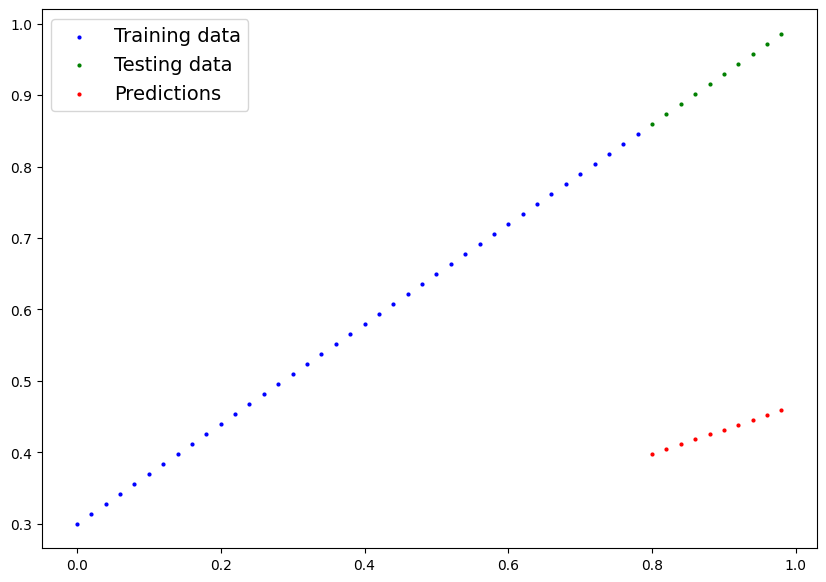

In [13]:
plot_predictions(predictions = y_pred )

### 3. Train model

The whole idea of training is for a model to move from some *unknown* parametrs (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:
* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters(e.g. weight & bias in our case) to improve the loss function.

  * Inside the optimizer you'll often have to set two parameters:
    * `params` - the model parameters you'd like to optimize for example `params = model_0.parameters()`
    * `lr` (learning rate) - the learning rate is a hyperparameter thet defines how big/small  the optimizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [14]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                               lr = 0.01) # lr = learning rate = possibly the most important hyperparameter you can set

**Q:** Which loss function and optimizer should I use?

**A:** This will be problem specific. But with experience, you'll get an idea of what works and what does'nt with your particular problem set.

For example, for a regression problem (like ours), a loss function of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice.

But for a classification problem like classifying weather a photo is of a dog or a cat, you'll likely want to use a loss function of `nn.BCELoss()` (binary cross entropy loss).

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backward through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [15]:
torch.manual_seed(42)
# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 100

epoch_count = []
train_loss_values = []
test_loss_values = []

### Training---------------------------------------------------
# 0. Loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # traing mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Claculate the loss
  loss = loss_fn(y_pred, y_train)
  # print(f'Loss: {loss}')

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop






  ### Testing----------------------------------------------
  model_0.eval()  # turns off different settings in the model not needed for evaluating/testing (droupout/batch norm layers)
  with torch.inference_mode():  # turns off gradient tracking & couple more things behind the scenes.
  # with torch.no_grad(): # you may also see torch.no_grad() in older PyTorch code
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)



  epoch_count.append(epoch)
  train_loss_values.append(loss)
  test_loss_values.append(test_loss)





  # print out what's happenin'------------------------------
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    # Print out the model state_dict()
    print(model_0.state_dict())


  model_0.state_dict()

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weight', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weight', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weight', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weight', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weight', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weight', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weight', tensor([0.5116])), ('bias', tensor([0.3788]))])
E

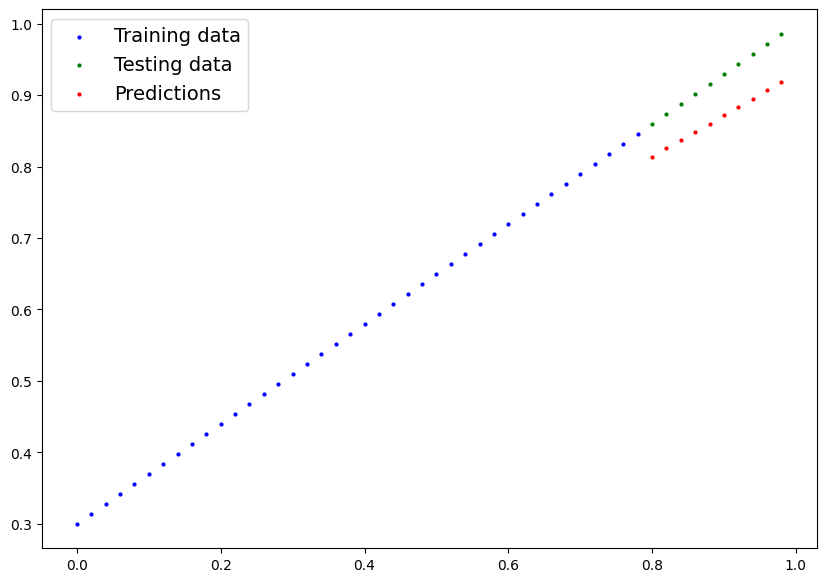

In [16]:
# plot_predictions(predictions=y_preds)
with torch.inference_mode():
  y_pred_new = model_0(X_test)
  plot_predictions(predictions = y_pred_new)

In [17]:
model_0.state_dict(), weight, bias

(OrderedDict([('weight', tensor([0.5784])), ('bias', tensor([0.3513]))]),
 0.7,
 0.3)

In [18]:
epoch_count, train_loss_values, test_loss_values

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99],
 [tensor(0.3129, grad_fn=<MeanBackward0>),
  tensor(0.3014, grad_fn=<MeanBackward0>),
  tensor(0.2898, grad_fn=<MeanBackward0>),
  tensor(0.2783, grad_fn=<MeanBackward0>),
  tensor(0.2668, grad_fn=<MeanBackward0>),
  tensor(0.2553, grad_fn=<MeanBackward0>),
  tensor(0.2438, grad_fn=<MeanBackward0>),
  tensor(0.2322, grad_fn=<MeanBackward0>),
  tensor(0.2207, grad_fn=<MeanBackward0>),
  tensor(0.2092, grad_

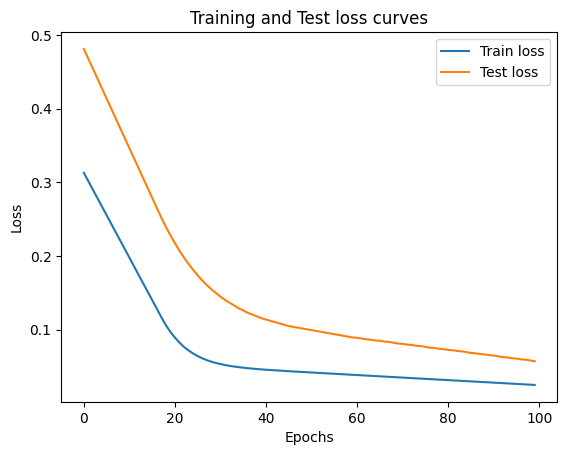

In [19]:
import numpy as np

plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).numpy()), label = 'Train loss')
plt.plot(epoch_count, test_loss_values, label = 'Test loss')
plt.title("Training and Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

### Saving a model in PyTorch

therte are three main methods you should know about for saving and loading models in PyTorch.
1. `torch.save()` - allows you save a PyTorch object in Python's pickle format
2. `torch.load()` - allo9ws you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [20]:
# Saving our PyTorch model
from pathlib import Path

# 1. create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [21]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 May  3 15:24 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [22]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [23]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)

# since LinearregressionModule() is a subclass of "nn.Module", we can directly call ".load_state_dict()" with loaded_model_0
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

<All keys matched successfully>

In [24]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [25]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

### 6. Putting it all together

Let's go back through the steps above and see it all in one place.

In [26]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# check PyTorch version
torch.__version__

'2.2.1+cu121'

Create device-agnostic code.

This means if we've got access to a GPU, our code will use it(for potentially faster computing).

if no GPU is available, the code will default to using CPU

In [27]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


### 6.1 Data

In [28]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start,end,step).unsqueeze(dim=1) # without unsqueeze, errors will pop up
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [29]:
# Split data
train_split = int(0.8*len(X))

X_train,y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

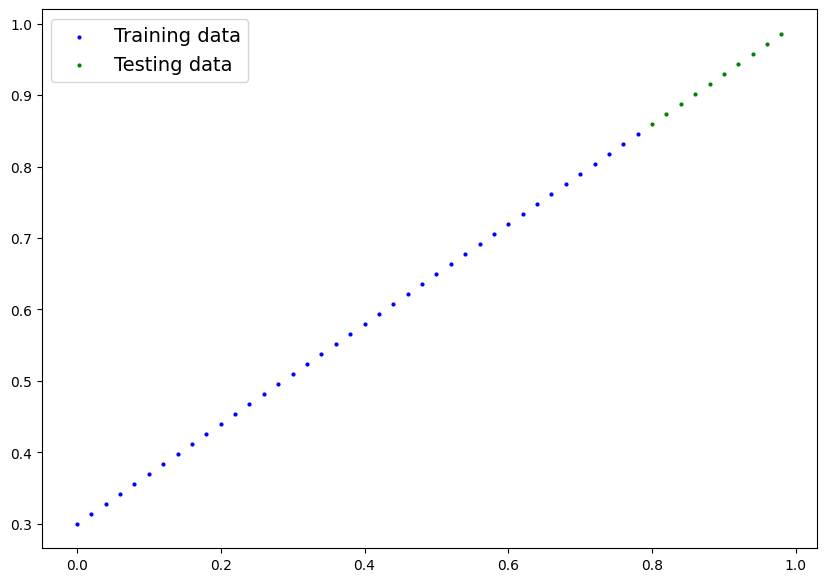

In [30]:
# Plot the data
# Note: if you don't have the plot_predictions() function loaded, this will error
plot_predictions(X_train,y_train,X_test,y_test)

### 6.2 Building a PyTorch Linear model

In [31]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters / also called: Linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features = 1,
                                  out_features = 1)

  def forward(self, x : torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual_seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [32]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [33]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [34]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.01)

In [37]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # print out what's happenin'
  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [40]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Making and evaluating mode

In [41]:
# Turn model into evaluation mode
model_1.eval()

# Make preditions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

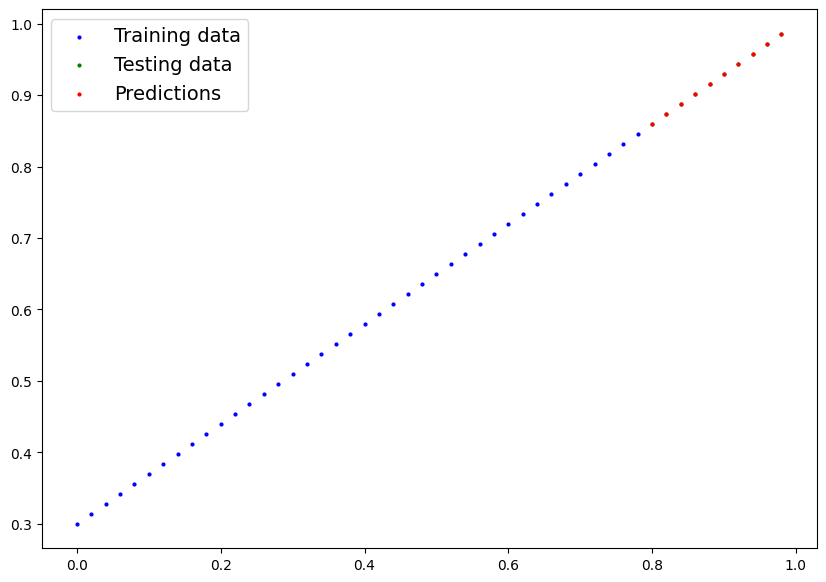

In [46]:
# Check out our model predictions visually
plot_predictions(predictions = y_preds.cpu()) # since the tensors are on the CUDA, and matplotlib works with numpy on CPU, we should use `<CUDA Tensor>.cpu()`.

### 6.5 Saving & loading a trained model

In [49]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create mode save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving modelto: {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(),
           f = MODEL_SAVE_PATH)

Saving modelto: models/01_pytorch_workflow_model_1.pth


In [50]:
# Load a PyTorch

# Create a nwe instance of linear regression model V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [51]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [52]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [54]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
print(loaded_model_1_preds)
y_preds == loaded_model_1_preds # checking weather the outputs of loaded and original model are same

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

## Exercises & Extra_curriculum